## 2. Time series prediction with RNN

In [1]:
import collections
import re
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [3]:
lines[0:10]

['the time machine by h g wells',
 '',
 '',
 '',
 '',
 'i',
 '',
 '',
 'the time traveller for so it will be convenient to speak of him',
 'was expounding a recondite matter to us his grey eyes shone and']

In [4]:
def tokenize(lines, token='word'):  #@save
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [5]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {
            token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):  #@save
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [6]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [7]:
for i in [0, 9]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
indices: [7, 1420, 5, 2185, 587, 6, 126, 25, 330, 127, 439, 3]


In [8]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)


(170580, 28)

In [9]:
vocab.idx_to_token

['<unk>',
 ' ',
 'e',
 't',
 'a',
 'i',
 'n',
 'o',
 's',
 'h',
 'r',
 'd',
 'l',
 'm',
 'u',
 'c',
 'f',
 'w',
 'g',
 'y',
 'p',
 'b',
 'v',
 'k',
 'x',
 'z',
 'j',
 'q']

In [10]:
corpus

[3,
 9,
 2,
 1,
 3,
 5,
 13,
 2,
 1,
 13,
 4,
 15,
 9,
 5,
 6,
 2,
 1,
 21,
 19,
 1,
 9,
 1,
 18,
 1,
 17,
 2,
 12,
 12,
 8,
 5,
 3,
 9,
 2,
 1,
 3,
 5,
 13,
 2,
 1,
 3,
 10,
 4,
 22,
 2,
 12,
 12,
 2,
 10,
 1,
 16,
 7,
 10,
 1,
 8,
 7,
 1,
 5,
 3,
 1,
 17,
 5,
 12,
 12,
 1,
 21,
 2,
 1,
 15,
 7,
 6,
 22,
 2,
 6,
 5,
 2,
 6,
 3,
 1,
 3,
 7,
 1,
 8,
 20,
 2,
 4,
 23,
 1,
 7,
 16,
 1,
 9,
 5,
 13,
 17,
 4,
 8,
 1,
 2,
 24,
 20,
 7,
 14,
 6,
 11,
 5,
 6,
 18,
 1,
 4,
 1,
 10,
 2,
 15,
 7,
 6,
 11,
 5,
 3,
 2,
 1,
 13,
 4,
 3,
 3,
 2,
 10,
 1,
 3,
 7,
 1,
 14,
 8,
 1,
 9,
 5,
 8,
 1,
 18,
 10,
 2,
 19,
 1,
 2,
 19,
 2,
 8,
 1,
 8,
 9,
 7,
 6,
 2,
 1,
 4,
 6,
 11,
 3,
 17,
 5,
 6,
 23,
 12,
 2,
 11,
 1,
 4,
 6,
 11,
 1,
 9,
 5,
 8,
 1,
 14,
 8,
 14,
 4,
 12,
 12,
 19,
 1,
 20,
 4,
 12,
 2,
 1,
 16,
 4,
 15,
 2,
 1,
 17,
 4,
 8,
 1,
 16,
 12,
 14,
 8,
 9,
 2,
 11,
 1,
 4,
 6,
 11,
 1,
 4,
 6,
 5,
 13,
 4,
 3,
 2,
 11,
 1,
 3,
 9,
 2,
 16,
 5,
 10,
 2,
 1,
 21,
 14,
 10,
 6,
 2,
 11,
 1,
 21,

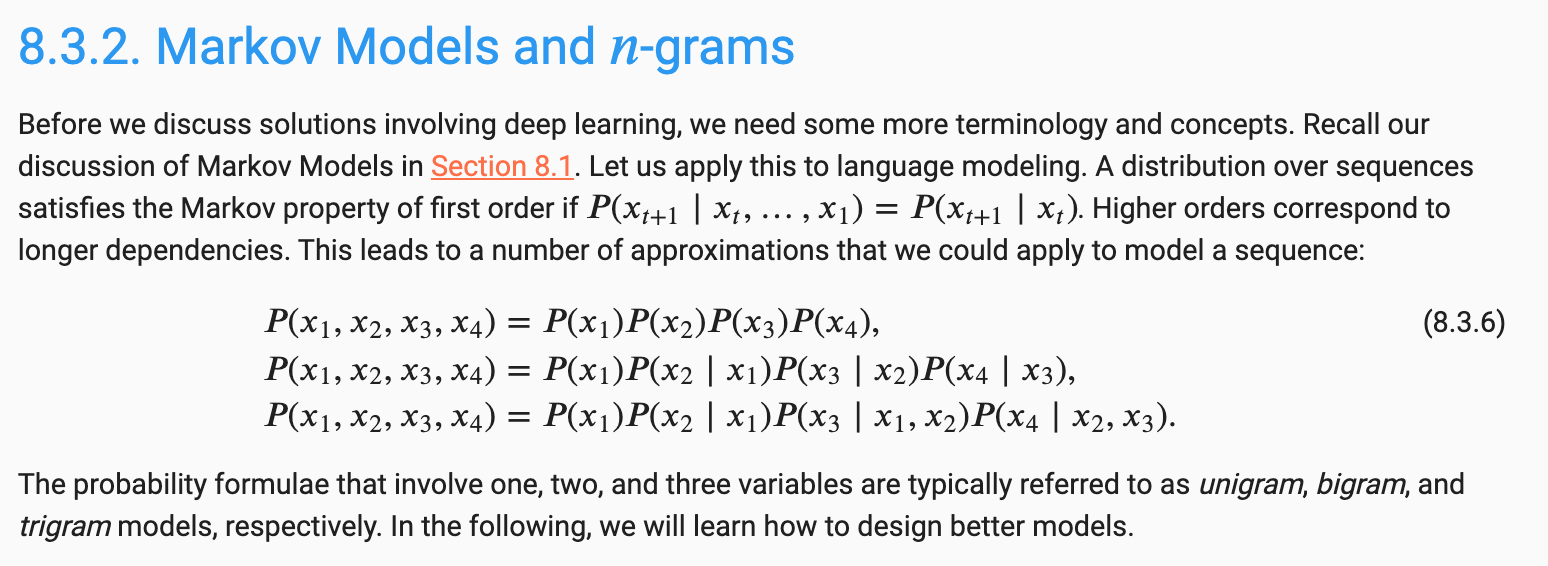

In [11]:
import random
import torch
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())
# Since each text line is not necessarily a sentence or a paragraph, we
# concatenate all text lines
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

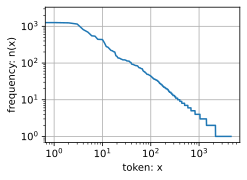

In [12]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log',
         yscale='log')

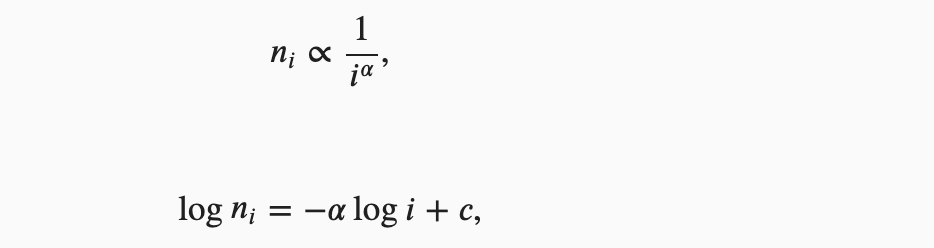

In [13]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [14]:
trigram_tokens = [
    triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

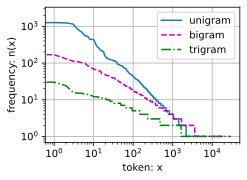

In [15]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

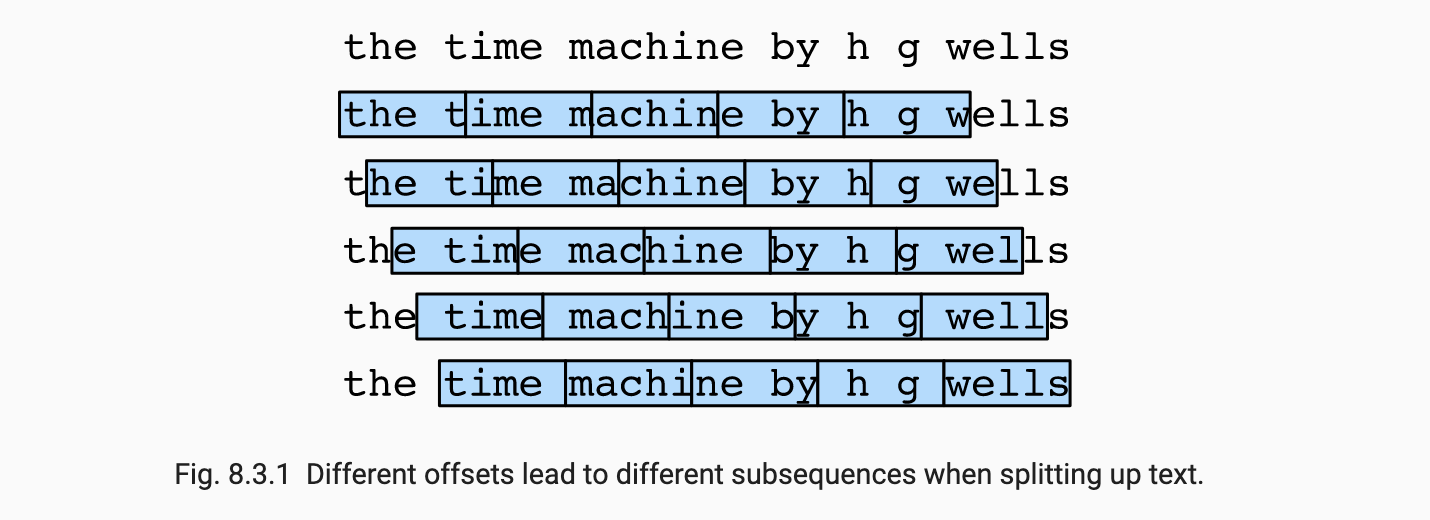

### way 1: Random Sampling 

In [16]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [17]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[27, 28, 29, 30, 31],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[28, 29, 30, 31, 32],
        [ 8,  9, 10, 11, 12]])
X:  tensor([[12, 13, 14, 15, 16],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [23, 24, 25, 26, 27]])
X:  tensor([[ 2,  3,  4,  5,  6],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]])


### way 2: Sequential Sampling 

In [18]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y
        
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)
# note sample X1 X2 X3 are consecutive 

X:  tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X:  tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


In [19]:
class SeqDataLoader:  #@save
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
    
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab

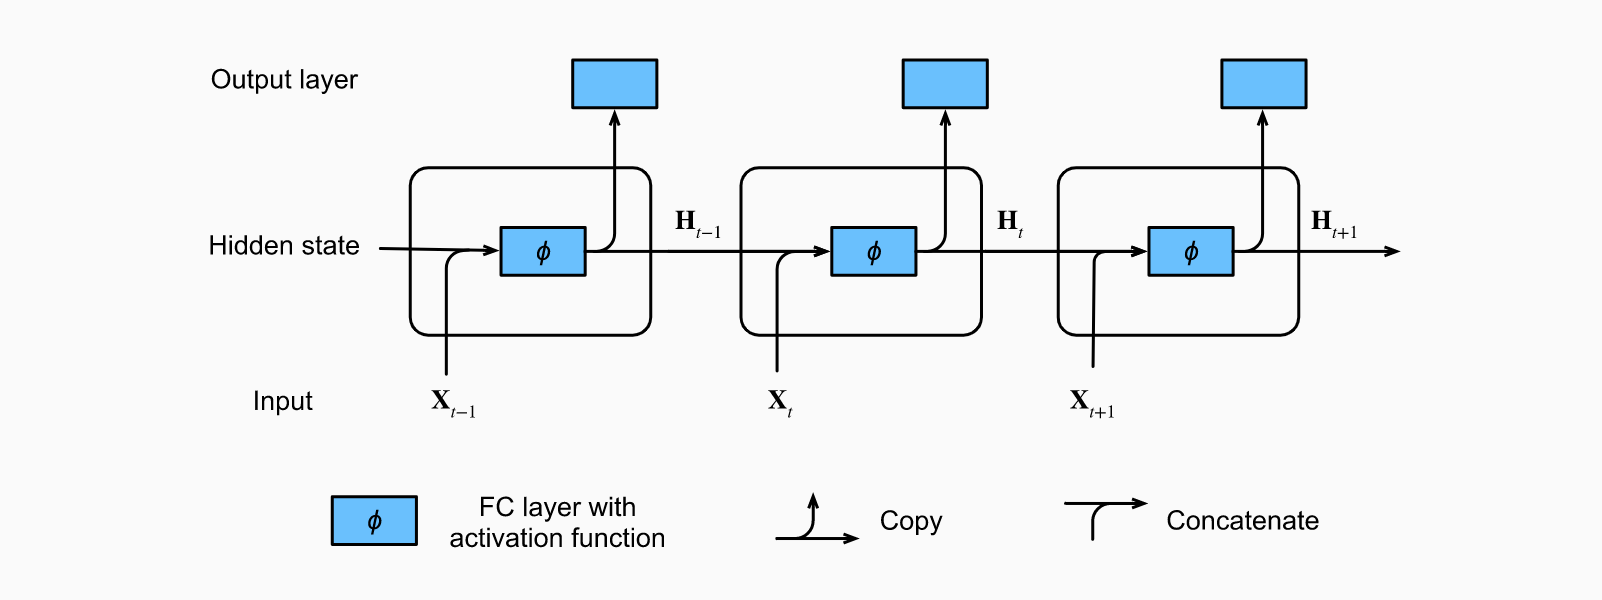

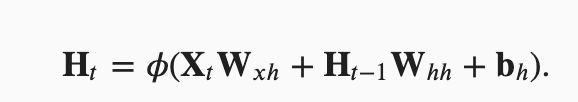

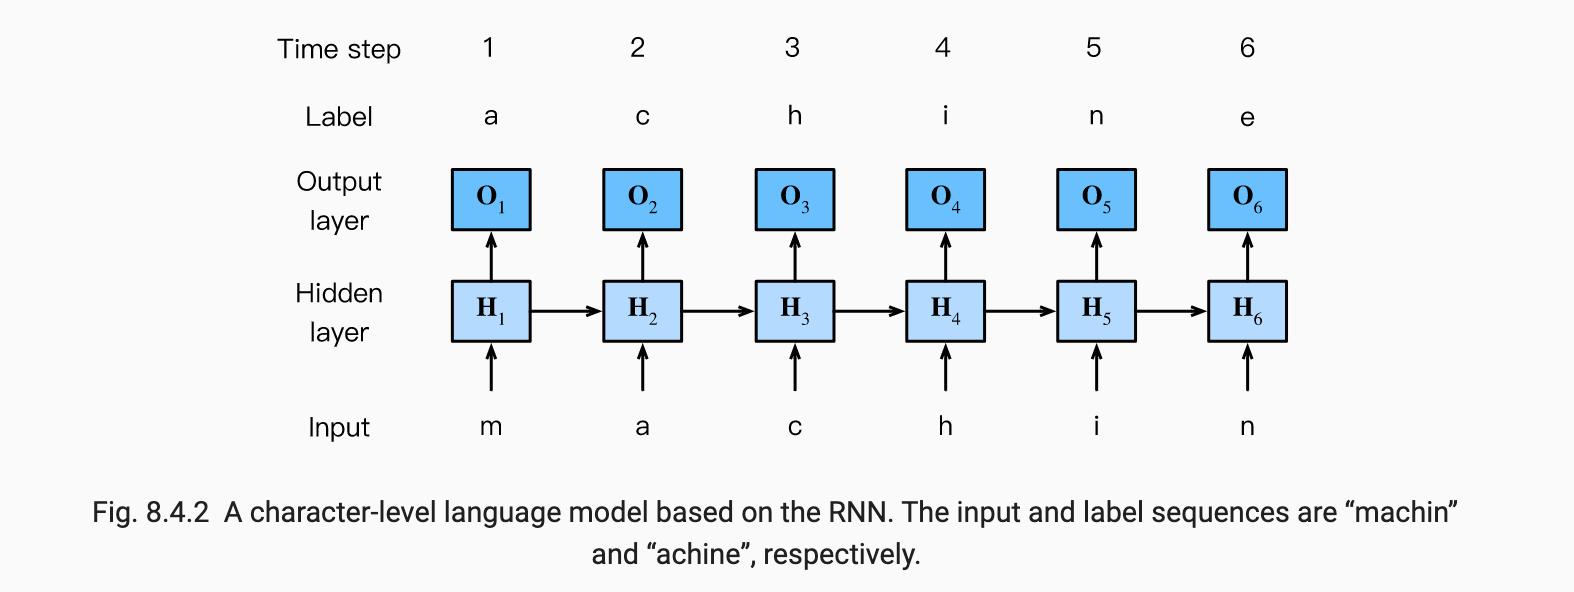

In [20]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [21]:
next(iter(train_iter))[0].shape, next(iter(train_iter))[1].shape, len(vocab)

(torch.Size([32, 35]), torch.Size([32, 35]), 28)

In [22]:
next(iter(train_iter))[0]

tensor([[12,  8,  5,  ..., 17,  5, 12],
        [ 4,  8,  9,  ..., 14, 10,  1],
        [ 1, 17,  2,  ..., 10,  6,  2],
        ...,
        [ 7, 14,  3,  ..., 10,  8, 12],
        [ 4, 10,  2,  ...,  7, 17,  1],
        [ 2, 11,  1,  ...,  4,  1, 15]])

In [23]:
# for example: 
F.one_hot(torch.tensor([0, 2]), len(vocab))


tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [24]:
# example:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [25]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [26]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [27]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [28]:
class RNNModelScratch:  #@save
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [29]:
X.shape

torch.Size([2, 5])

In [30]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [32]:
def grad_clipping(net, theta):  #@save
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [33]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [36]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

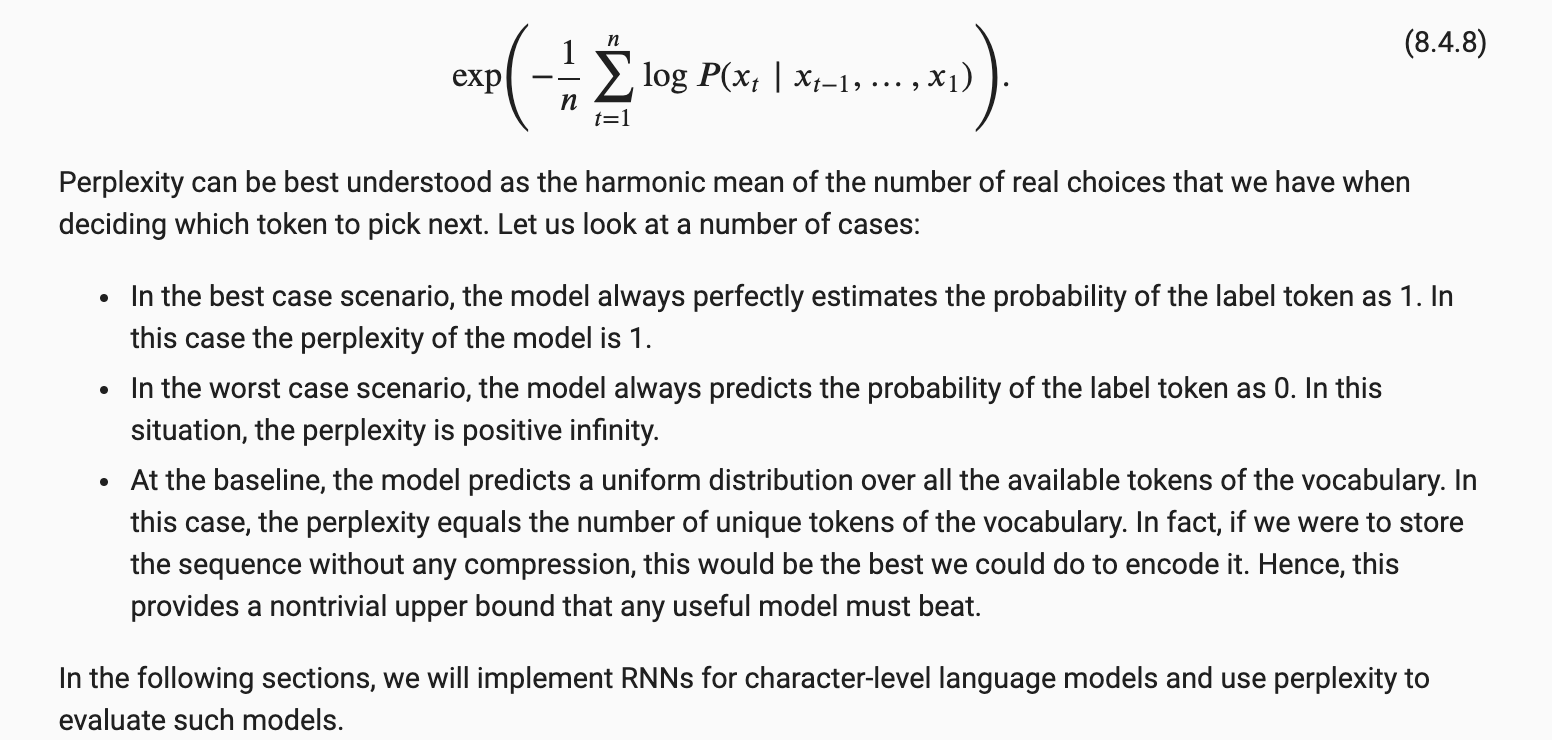

perplexity 1.0, 18710.6 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


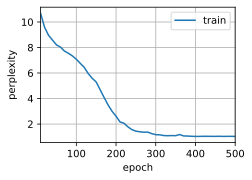

In [37]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

Different sampling methods for sequential data (random sampling and sequential partitioning) will result in differences in the initialization of hidden states.

We clip the gradients before updating the model parameters. This ensures that the model does not diverge even when gradients blow up at some point during the training process.

We use perplexity to evaluate the model. As discussed in Section 8.4.4, this ensures that sequences of different length are comparable.

In [38]:
d2l.predict_ch8('time traveller ', 31, net, vocab, d2l.try_gpu())


'time traveller for so it will be convenient to'

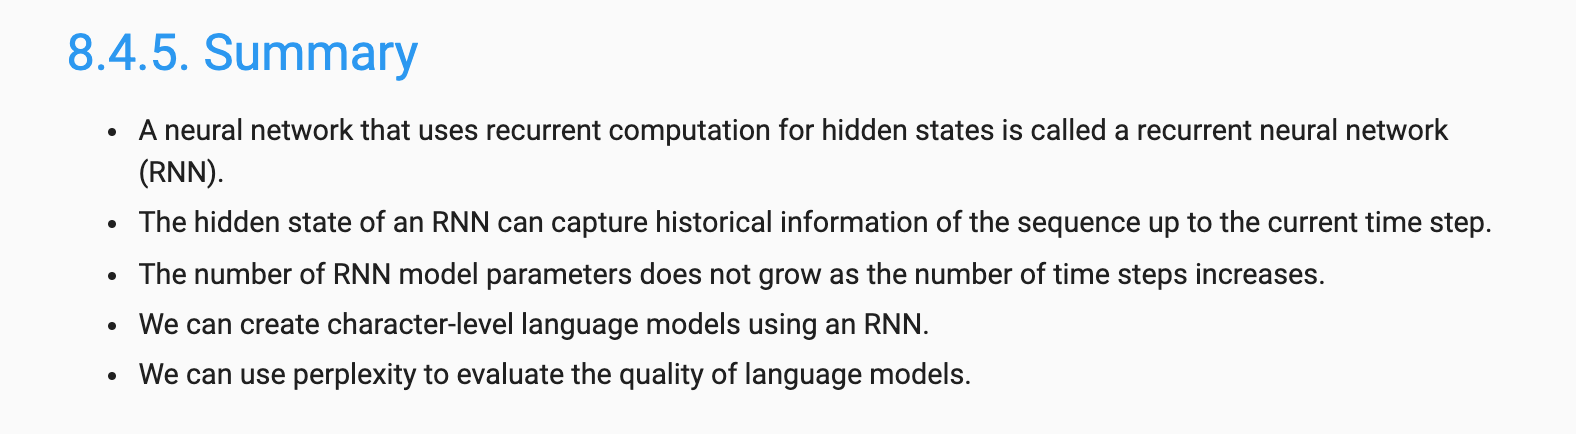